Let's make a metric that lets us quantify the uncertainty in a shape measured off a serries of images

For the systematic. It might make sense to assume a perfectly circular object, then compute the SNR on a systematic effect, say, a stretch in the x-dimension. 

General intuitive checks of a weak lensing metric

* if the atmospheric seeing gets better, metric should get better
* if images are deeper, metric should get better
* if there are more observations of similar quality, metric should get better
* if we use a brighter fiducial object, metric should get better
* if we observe a region of sky with less dust, metric should get better


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.photUtils import Sed, Bandpass
from shape_metric import Size_precision_metric, Systematic_angle_metric

In [2]:
dbFile = 'baseline_nexp2_v1.7_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
bundleList = []
sql = ''
metric = Size_precision_metric()
slicer = slicers.HealpixSlicer(useCache=False)
summaryStats = []
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'filter', 'airmass', 'visitExposureTime', 'seeingFwhmGeom', 'fieldDec', 'skyBrightness', 'fieldRA'].
Found 2045493 visits
Running:  ['opsim_SizePrecision_HEAL']


/Users/yoachim/git_repos/21_Scratch/shape_metric/shape_metric.py:128: RuntimeWarning: divide by zero encountered in true_divide
  sigma_fwhm_object_predeconv = 1.4*fwhm_observed*(self.phot_parameters.pixscale/fwhm_observed)**0.5*noise_at_peak/peak_counts
/Users/yoachim/git_repos/21_Scratch/shape_metric/shape_metric.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  result = self.fwhm_object/np.sum(1./sigma_fwhm_object**2)**-0.5
/Users/yoachim/git_repos/21_Scratch/shape_metric/shape_metric.py:131: RuntimeWarning: overflow encountered in square
  sigma_fwhm_object = (sigma_fwhm_object_predeconv**2 + sigma_fwhm_refstar**2)**0.5


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 267 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 436.486  dipole: lon: 49.6014, lat: -59.0101, amp: 123.284
  mono, lon, lat, amp


Plotting complete.


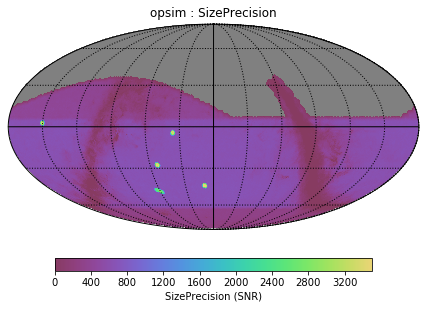

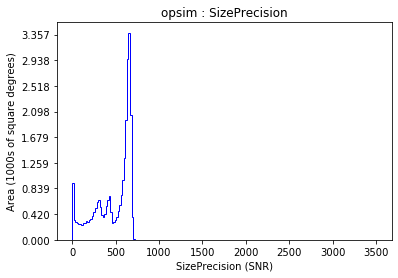

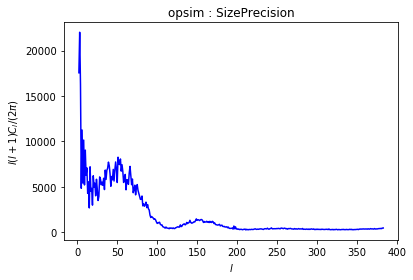

In [4]:
bg.plotAll(closefigs=False)

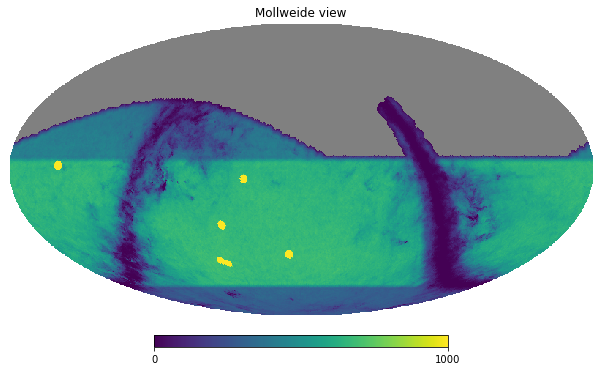

In [5]:
hp.mollview(bundleList[0].metricValues, max=1000)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint filter="r" for columns ['fiveSigmaDepth', 'filter', 'airmass', 'rotTelPos', 'visitExposureTime', 'seeingFwhmGeom', 'fieldDec', 'rotSkyPos', 'skyBrightness', 'fieldRA']
Found 452001 visits
Running:  ['opsim_AngularSysrotTel_r_HEAL', 'opsim_AngularSysrotSky_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="r"" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 1365 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 0.0118515  dipole: lon: -106.536, lat: 70.6282, amp: 0.00118609
  mono, lon, lat, amp
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 1663 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 0.0116079  dipole: lon: -85.5347, lat: 65.8339, amp: 0.00115267
  mono, lon, lat, amp


Plotting complete.


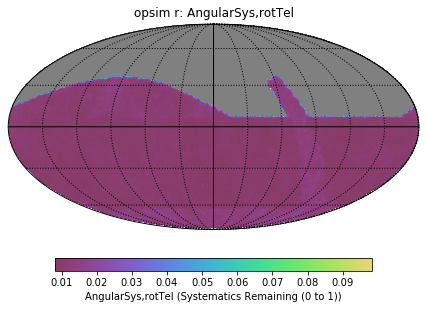

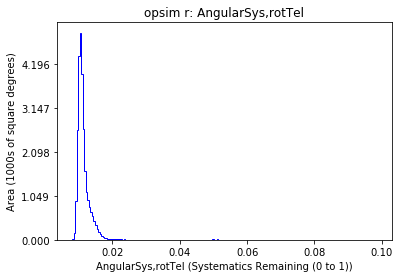

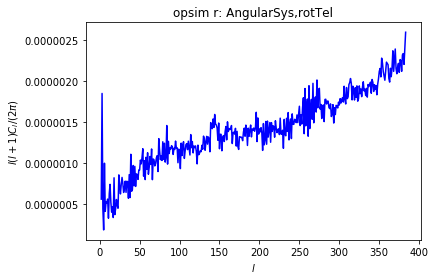

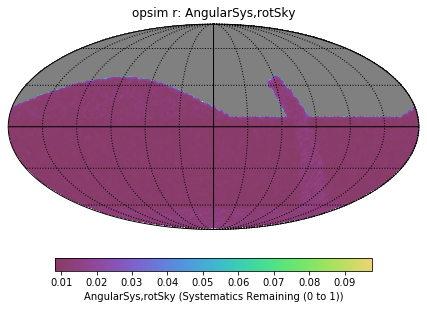

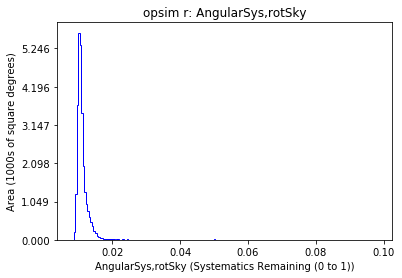

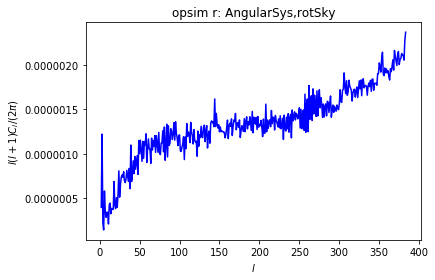

In [6]:
bundleList = []
# systematics should probably be per filter?
sql = 'filter="r"'
metric = Systematic_angle_metric(angleCol='rotTelPos', metricName='AngularSys,rotTel')
slicer = slicers.HealpixSlicer(useCache=False)
summaryStats = []
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))
metric = Systematic_angle_metric(angleCol='rotSkyPos', metricName='AngularSys,rotSky')
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))


bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

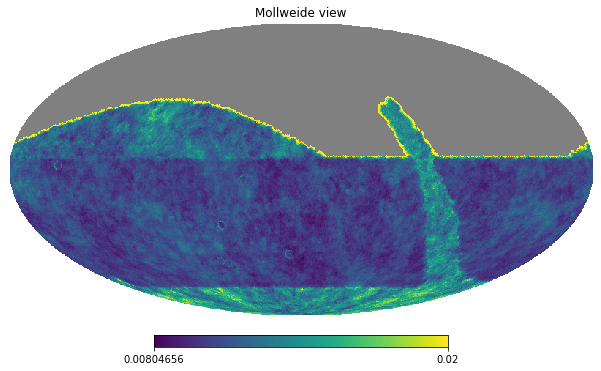

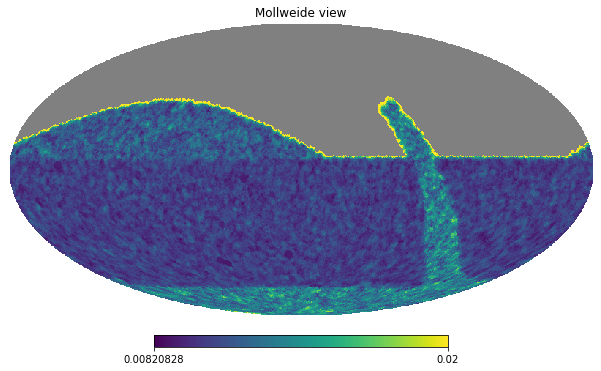

In [7]:
hp.mollview(bundleList[0].metricValues, max=0.02)
hp.mollview(bundleList[1].metricValues, max=0.02)


In [8]:
dbFile = 'spiders_v1.5_10yrs.db'
conn = db.OpsimDatabase(dbFile)
bundleList = []
sql = 'filter="r"'
metric = Systematic_angle_metric()
slicer = slicers.HealpixSlicer(useCache=False)
summaryStats = []
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
#bg.plotAll(closefigs=False)


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint filter="r" for columns ['fiveSigmaDepth', 'filter', 'airmass', 'rotTelPos', 'visitExposureTime', 'seeingFwhmGeom', 'fieldDec', 'skyBrightness', 'fieldRA']
Found 492318 visits
Running:  ['opsim_AngularSystematics_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


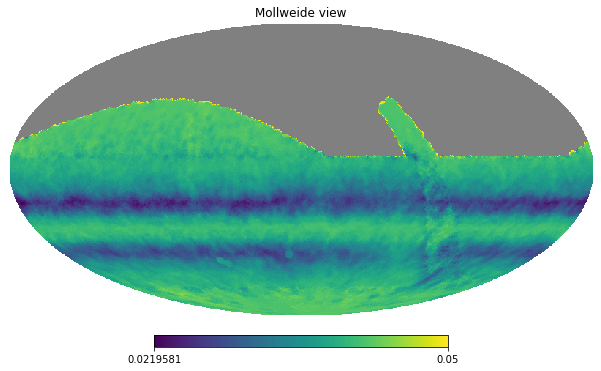

In [9]:
hp.mollview(bundleList[0].metricValues, max=.05)

In [10]:
dbFile = 'spiders_v1.5_10yrs.db'
conn = db.OpsimDatabase(dbFile)
bundleList = []
sql = 'filter="r"'
metric = Systematic_angle_metric(angleCol='rotSkyPos')
slicer = slicers.HealpixSlicer(useCache=False)
summaryStats = []
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summaryStats))
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
#bg.plotAll(closefigs=False)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database SummaryAllProps with constraint filter="r" for columns ['fiveSigmaDepth', 'filter', 'airmass', 'visitExposureTime', 'seeingFwhmGeom', 'fieldDec', 'rotSkyPos', 'skyBrightness', 'fieldRA']
Found 492318 visits
Running:  ['opsim_AngularSystematics_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


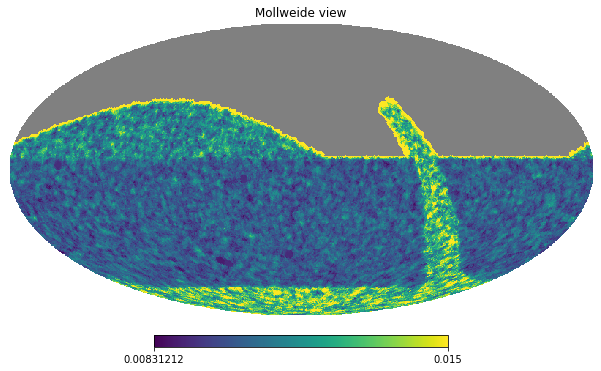

In [11]:
hp.mollview(bundleList[0].metricValues, max=.015)

In [12]:
# So, the final step might be to set thresholds for precision, 
# systematics in rotTelPos, systematics in rotSkyPos, then compute the sky area that meets it.
